# Task 1

https://github.com/flod1n/R7022E-AI-in-processindustry-and-automation/tree/main/Lab3_supervised

## Load data

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import cv2
from sklearn.model_selection import GridSearchCV

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((60, 60)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    # transforms.ToPILImage(),
    
    ])

dataset = datasets.ImageFolder(root="Data", transform=transform)

total_size = len(dataset)
train_size = int(0.80 * total_size) 
test_size = total_size - train_size

train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(69)
)

dataset.class_to_idx

Using device: cuda


{'Negative': 0, 'Positive': 1}

### Convert to numpy arrays

In [5]:
def extract_images(subset):
    X_list = []
    y_list = []

    for i in range(len(subset)):
        img, label = subset[i]   # img = tensor, label = int

        # Remove channel dimension (1, H, W -> H, W)
        img_np = img.squeeze(0).numpy()

        X_list.append(img_np)
        y_list.append(label)

    X = np.stack(X_list)    # shape: (N, H, W)
    y = np.array(y_list)    
    return X, y

X_train, y_train = extract_images(train_subset)
X_test,  y_test  = extract_images(test_subset)

## HOG

https://www.geeksforgeeks.org/computer-vision/histogram-of-oriented-gradients/

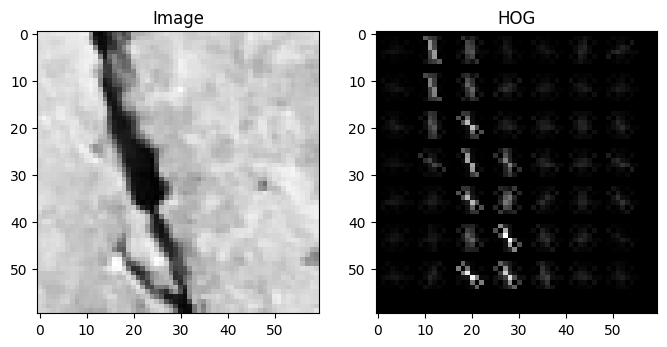

In [7]:
from skimage.feature import hog
from skimage import exposure
import numpy as np

hog_params = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys'
)

def extract_hog_features(X, hog_params):
    features = []
    for img in X:
        fd = hog(
            img,
            orientations=hog_params["orientations"],
            pixels_per_cell=hog_params["pixels_per_cell"],
            cells_per_block=hog_params["cells_per_block"],
            block_norm=hog_params["block_norm"],
            visualize=False,
            feature_vector=True
        )
        features.append(fd)
    return np.array(features)

X_train_hog = extract_hog_features(X_train, hog_params)
X_test_hog  = extract_hog_features(X_test,  hog_params)


img = X_train[0]
fd, hog_image = hog(img, **hog_params, visualize=True)

hog_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title("Image")
plt.subplot(1,2,2); plt.imshow(hog_rescaled, cmap='gray'); plt.title("HOG")
plt.show()


### Linear

In [4]:
from sklearn.svm import LinearSVC
import joblib

svc = LinearSVC()
svc.fit(X_train_hog,y_train)

joblib.dump(svc, 'SVM_Linear_hog.pkl')

['SVM_Linear_hog.pkl']

Accuracy: 0.981375
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3988
           1       0.98      0.98      0.98      4012

    accuracy                           0.98      8000
   macro avg       0.98      0.98      0.98      8000
weighted avg       0.98      0.98      0.98      8000



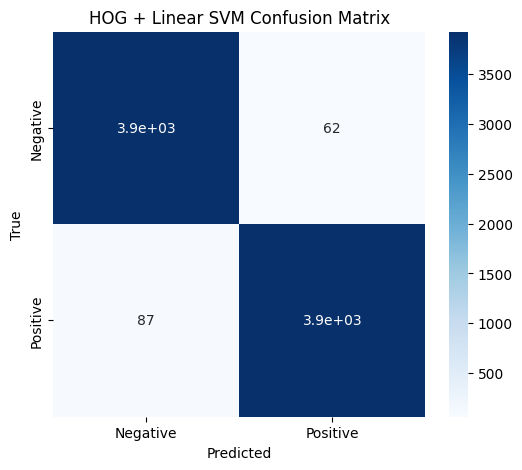

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

svc = joblib.load("SVM_Linear_hog.pkl")
pred = svc.predict(X_test_hog)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
# cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("HOG + Linear SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Poly

In [4]:
from sklearn.svm import SVC
import joblib

svc_poly = SVC(
    kernel='poly',
    C=10,
    gamma='scale',
    # probability=True
)

svc_poly.fit(X_train_hog, y_train)

joblib.dump(svc_poly, 'SVM_poly_hog.pkl')

['SVM_poly_hog.pkl']

Accuracy: 0.992375
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3988
           1       1.00      0.99      0.99      4012

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



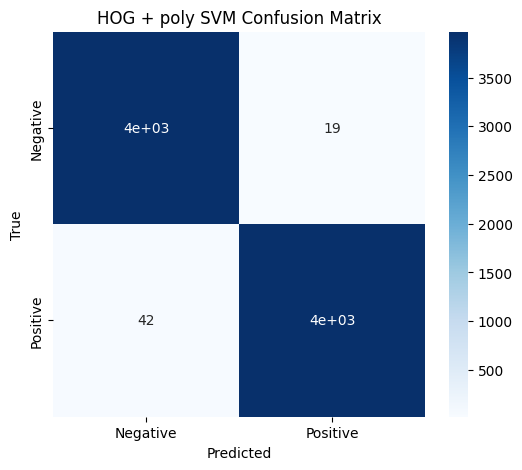

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

svc = joblib.load("SVM_poly_hog.pkl")
pred = svc.predict(X_test_hog)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
# cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("HOG + poly SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.svm import SVC
import joblib

param_grid={'C':[0.1,1,10,100],
            'gamma':["scale"],
            'kernel':['poly']}

svc = SVC(probability=True)

model = GridSearchCV(svc,param_grid)
model.fit(X_train_hog, y_train)

joblib.dump(model, 'gridsearch_SVM_poly.pkl')

['gridsearch_SVM_poly.pkl']

In [ ]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

gs = joblib.load("gridsearch_SVM_poly.pkl")
best_model = gs.best_estimator_

y_pred = best_model.predict(X_test_hog)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3988
           1       1.00      0.99      0.99      4012

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



### RBF
I don't know but RBF takes way too much time so i will skip it. I am pretty satisfied with the resuts from linear och polynomial.

## Raw pixel data

### Reshape

In [9]:
X_train_raw = X_train.reshape(X_train.shape[0], -1)
X_test_raw  = X_test.reshape(X_test.shape[0], -1)

X_train_raw.shape

(32000, 3600)

### Linear

In [5]:
from sklearn.svm import LinearSVC
import joblib

svc = LinearSVC()
svc.fit(X_train_raw,y_train)

joblib.dump(svc, 'SVM_Linear_raw.pkl')

['SVM_Linear_raw.pkl']

Accuracy: 0.885125
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      3988
           1       0.92      0.84      0.88      4012

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.88      8000
weighted avg       0.89      0.89      0.88      8000



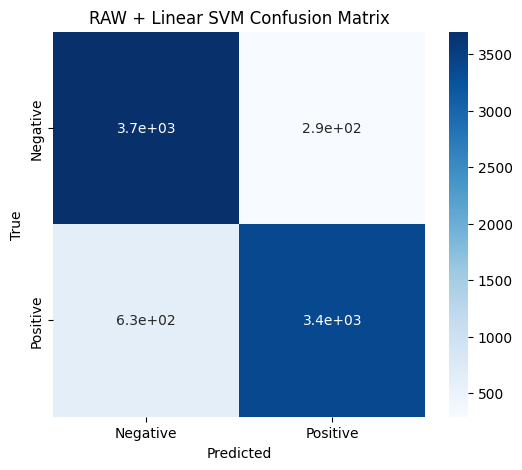

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import joblib

svc = joblib.load("SVM_Linear_raw.pkl")
pred = svc.predict(X_test_raw)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
# cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("RAW + Linear SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [7]:
from sklearn.svm import SVC
import joblib

svc_poly = SVC(
    kernel='poly',
    C=10,
    gamma='scale',
    # probability=True
)

svc_poly.fit(X_train_raw, y_train)

joblib.dump(svc_poly, 'SVM_poly_raw.pkl')

['SVM_poly_raw.pkl']

Accuracy: 0.953
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3988
           1       0.99      0.91      0.95      4012

    accuracy                           0.95      8000
   macro avg       0.96      0.95      0.95      8000
weighted avg       0.96      0.95      0.95      8000



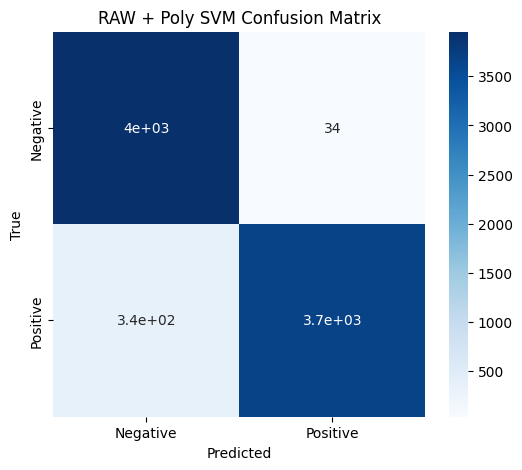

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

svc = joblib.load("SVM_poly_raw.pkl")
pred = svc.predict(X_test_raw)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
# cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues",
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title("RAW + Poly SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Evalutaion and discussion

So, the svm did great at classifying the images after a sufficient pre-preocessing/feature extraction. The polynomial kernel did better than the linear kernel, especially for the raw pixels. I guess it was expected, but there was no big difference when using HOG. I might re-run this experiment later to see how the number of dimensions, or resolution affect accuracy and how far we can push it with HOG for faster inferencing. 